In [1]:
from practical_part import *

In [2]:
schemes = {'C': [0.0, 0.3333333333333333, 0.6666666666666666, 0.0],
           'Minimum Viscosity': [-0.25, 0.583, 0.917, -0.25]}

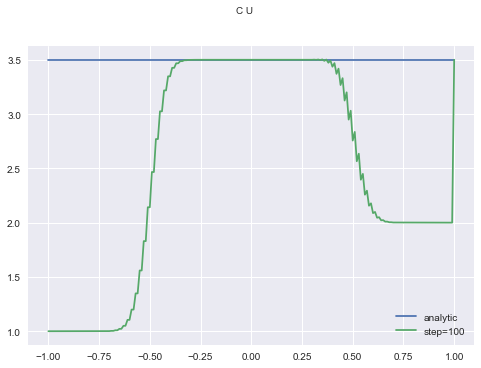

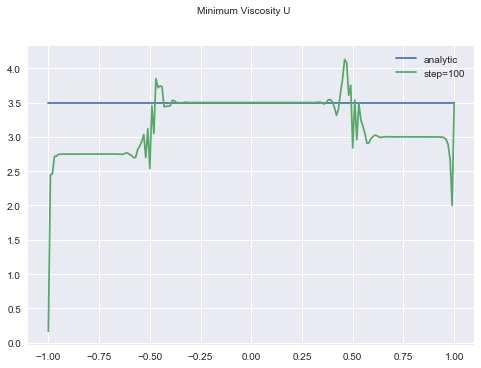

In [3]:
for item in schemes.items():
    solve(item)

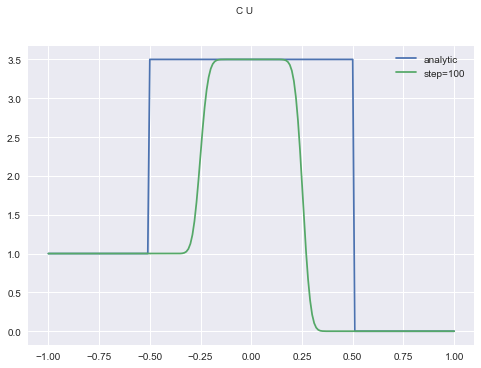

In [4]:
import numpy as np
import matplotlib.pyplot as plt

X = 1
n_x = 201
h = 2 * X / (n_x - 1)
tau = 0.25 * h
n_t = 101
xs = np.linspace(-1, X, n_x)

u_l = 1.0
u_r = 0.0
p_l = 5.0
p_r = 2.0
rho = 0.25
c = 2.0


def u_0(x):
    return u_l if x <= 0 else u_r


def p_0(x):
    return p_l if x <= 0 else p_r


def u_t(x, t):
    if x < -c * t:
        return u_l
    elif x > c * t:
        return u_r
    return (u_l + u_r) / 2 - (p_r - p_l) / (2 * rho * c)


def p_t(x, t):
    if x < -c * t:
        return p_l
    elif x > c * t:
        return p_r
    return - rho * c * (u_r - u_l) / 2 + (p_l + p_r) / 2


def a(c):
    return 1 / 10 - 3 * c / 5


def b(c):
    return 3 / 4 - 3 * c / 4


def d(c):
    return 3 * c / 5 - 3 / 5


def _a(c, d):
    return 1 / 4 - 3 * c / 4 + d / 4


def _b(c, d):
    return 3 / 4 - c / 4 - 5 * d / 4


schemes = {'A': [1 / 4, 3 / 4, 0, 0],
           'B': [2 / 5, 0, 0, 3 / 5],
           'C': [0, 2 / 3, 1 / 3, 0],
           'D': [0, 0, 1 / 2, 1 / 2],
           'O(^2)': [-7 / 34, 25 / 68, 26 / 51, -5 / 17],
           'O(^2)_down': [_a(1 / 3, -0.4), _b(1 / 3, -0.4), 1 / 3, -0.4],
           'O(^2)_up': [_a(0.7, -0.18), _b(0.7, -0.18), 0.7, -0.18],
           'O(^3)': [0, 2, 0, -1]}

hybrid = {'5p': [schemes['O(^2)_down'], schemes['O(^2)_up'], False],
          '6p1': [schemes['O(^2)_down'], schemes['O(^3)'], False],
          '6p2': [schemes['O(^2)_up'], schemes['O(^3)'], False],
          '7p': [schemes['O(^3)'], schemes['O(^2)_down'], schemes['O(^2)_up']]}

step = 100


def solve(scheme):
    arr = scheme[1]
    Y = np.zeros((n_t, n_x))
    Z = np.zeros((n_t, n_x))
    for i in range(n_x):
        Y[0][i] = u_0(xs[i]) + p_0(xs[i]) / c / rho
        Y[1][i] = u_0(xs[i] - c * tau) + p_0(xs[i] - c * tau) / c / rho
        Z[0][i] = u_0(xs[i]) - p_0(xs[i]) / c / rho
        Z[1][i] = u_0(xs[i] + c * tau) - p_0(xs[i] + c * tau) / c / rho

    for i in range(n_t):
        Y[i][0] = u_t(xs[0], tau * i) + p_t(xs[0], tau * i) / c / rho
        Y[i][-1] = u_t(xs[-1], tau * i) + p_t(xs[-1], tau * i) / c / rho
        Z[i][0] = u_t(xs[0], tau * i) - p_t(xs[0], tau * i) / c / rho
        Z[i][-1] = u_t(xs[-1], tau * i) - p_t(xs[-1], tau * i) / c / rho

    for j in range(1, n_t - 1):
        for i in range(1, n_x):
            Y[j + 1][i] = arr[0] * Y[j][i - 1] + arr[1] * Y[j][i] + \
                          arr[2] * Y[j - 1][i - 1] + arr[3] * Y[j - 1][i]
        for i in range(0, n_x - 1):
            Z[j + 1][i] = arr[0] * Z[j][i + 1] + arr[1] * Z[j][i] + \
                          arr[2] * Z[j - 1][i + 1] + arr[3] * Z[j - 1][i]

    _plot(scheme[0], Y[step], Z[step])


def _plot(name, u, v):
    fig = plt.figure()
    fig.suptitle(name + " " + "U", fontsize=10)
    # plt.plot(xs, [u_0(x) for x in xs], label='initial')
    # plt.plot(xs, [p_t(x, step * tau) for x in xs], label='analytic')
    # plt.plot(xs, rho * c * (u - v) / 2, label='step={}'.format(step))
    plt.plot(xs, [u_t(x, step * tau) for x in xs], label='analytic')
    plt.plot(xs, (u + v) / 2, label='step={}'.format(step))
    plt.legend()
    plt.show()


for scheme in schemes.items():
    if scheme[0] == 'C':
        solve(scheme)